# NE551 Stopping Power Assignment #

## Using the stopping power equations for *heavy ions*, develop a code that will: ##

### Calculate the collisional mass stopping power of a charged particle (heavy ions with a given charge, Z) and kinetic energy through the materials listed below. For this assignment, heavy ions are any charged particle with mass greater than or equal to the proton ###

In [1]:
%%javascript
MathJax.Extension["TeX/cancel"]={version:"2.4.0",ALLOWED:{color:1,mathcolor:1,background:1,mathbackground:1,padding:1,thickness:1}};MathJax.Hub.Register.StartupHook("TeX Jax Ready",function(){var c=MathJax.InputJax.TeX,a=MathJax.ElementJax.mml,b=MathJax.Extension["TeX/cancel"];b.setAttributes=function(h,e){if(e!==""){e=e.replace(/ /g,"").split(/,/);for(var g=0,d=e.length;g<d;g++){var f=e[g].split(/[:=]/);if(b.ALLOWED[f[0]]){if(f[1]==="true"){f[1]=true}if(f[1]==="false"){f[1]=false}h[f[0]]=f[1]}}}return h};c.Definitions.Add({macros:{cancel:["Cancel",a.NOTATION.UPDIAGONALSTRIKE],bcancel:["Cancel",a.NOTATION.DOWNDIAGONALSTRIKE],xcancel:["Cancel",a.NOTATION.UPDIAGONALSTRIKE+" "+a.NOTATION.DOWNDIAGONALSTRIKE],cancelto:"CancelTo"}},null,true);c.Parse.Augment({Cancel:function(e,g){var d=this.GetBrackets(e,""),f=this.ParseArg(e);var h=b.setAttributes({notation:g},d);this.Push(a.menclose(f).With(h))},CancelTo:function(e,g){var i=this.ParseArg(e),d=this.GetBrackets(e,""),f=this.ParseArg(e);var h=b.setAttributes({notation:a.NOTATION.UPDIAGONALSTRIKE+" "+a.NOTATION.UPDIAGONALARROW},d);i=a.mpadded(i).With({depth:"-.1em",height:"+.1em",voffset:".1em"});this.Push(a.msup(a.menclose(f).With(h),i))}});MathJax.Hub.Startup.signal.Post("TeX cancel Ready")});MathJax.Ajax.loadComplete("[MathJax]/extensions/TeX/cancel.js");

<IPython.core.display.Javascript object>

In [32]:
import pyne.data as data
import math
import scipy.constants as const
import json
import pyne.material
from pyne import nucname
from pyne import nuc_data
mats = pyne.material.MaterialLibrary(nuc_data, datapath='/material_library/materials', nucpath='/material_library/nucid')

Equation 2.22 from Anderson: 

\begin{equation}
S_c = 4 z^2 \pi r_0^2 m_e \cancel{c^2} N_A \frac{Z}{M_m} \rho \frac{\left( T + M \cancel{c^2} \right) ^2}{T \left( T + 2 M \cancel{c^2} \right) } \ln \left( \frac{2 m_e \cancel{c^2} T \left( T + 2 M \cancel{c^2} \right) }{I \left( T + M \cancel{c^2} \right)^2} \right)
\end{equation}
This is equivalent to:
\begin{equation}
S_c = 4 z^2 \pi r_0^2 \frac{m_e \cancel{c^2} }{\beta^2} \frac{N_A \rho}{M_m} Z \ln \left( \frac{2 m_e \cancel{c^2} \gamma^2 \beta^2}{I} \right)
\end{equation}
To calculate the collisional \textit{mass} stopping power, divide this by $ \rho $:
\begin{equation}
S_c = 4 z^2 \pi r_0^2 \frac{m_e}{\beta^2} \frac{N_A}{M_m} Z \ln \left( \frac{2 m_e \gamma^2 \beta^2}{I} \right)
\end{equation}

First, import useful constants (polluting the namespace):

In [33]:
pi = math.pi
r_e = const.value('classical electron radius') * 100.0 # Convert 1m = 100cm
m_e = const.value('electron mass energy equivalent in MeV')
N_A = const.value('Avogadro constant')
m_to_e = const.physical_constants['atomic mass constant energy equivalent in MeV'][0]

In [133]:
def I(material):
    """ Looks up the Adjusted Average Excitation Energy if Z<=13. Otherwise calculates it
        Output units are in MeV
    """
    # Lookup table for Z<=13. Key is the "Z" of the material. Values are in eV
    lookup_table = {
        1: 18.9,
        2: 42.0,
        3: 38.0,
        4: 60.0, 
        6: 78.0,
        7: 85.0,
        8: 89.0,
        10: 131.0,
        13: 163.0
    }
    
    I_list = []
    
    for mat, frac in material.mult_by_mass().items():
        Z = nucname.znum(mat)
        # Check to see if Z is in our table
        I = lookup_table.get(Z)

        # If I is not in the table, calculate it
        # Use Anderson Equation 2.33
        if I is None:
            I = 9.73 * Z + 58.8 * Z ** -0.19
            
        I_list.append(I * frac)
    
    I_a = sum(I_list)
    
    # Convert I from eV to MeV
    I_a = I_a * 10**-6.0
    
    return I_a

In [134]:
def beta_squared(T, m):
    """ Gives value of beta^2 for a given Mass (MeV/c^2) and Kinetic Energy (MeV)
    """
    numerator = T * (T + 2 * m)
    denominator = (T + m) ** 2
    return numerator / denominator

In [135]:
def gamma_squared(T, m):
    """ Gives value of gamma^2 for a given mass (MeV/c^2) and Kinetic Energy (MeV)
    """
    return 1.0 / (1 - beta_squared(T, m)) ** 0.5

In [136]:
def Z_eff(material):
    """ Returns the effective Z/M == Z/A of a material
    """
    return sum([1.0 * nucname.znum(m) / data.atomic_mass(m) * f for m, f in material.mult_by_mass().items()])

In [137]:
allowed_materials = [
    mats["Concrete, Portland"],
    mats["Tissue, Adipose (ICRP)"],
    mats["Water, Liquid"],
    mats["Air (dry, near sea level)"]
]

In [157]:
def S_c(incident, target, T, M_b):
    """ Returns the stopping power in MeV/cm
        T in MeV
        density in g/cm^3
        Output in MeV/cm
    """
    # Currently the incident and target are specified in Z number. incident is assumed to be fully ionized
    z = incident
    Z = target
    
    # Convert the mass of the beam particles into MeV
    M_b = M_b * m_to_e
    
    first = 4 * (z ** 2) * pi * (r_e ** 2) * m_e
    second = N_A * Z_eff(target) # TODO: Take M_m from a Pyne material
    third = 1.0 / beta_squared(T, M_b)
    logpart = (2 * m_e * beta_squared(T, M_b) * gamma_squared(T, M_b)) / (I(Z))
    fourth = math.log(logpart) - beta_squared(T, M_b) + beta_squared(T, M_b)
    
    # print I(Z)
    # print Z_eff(target)
    
    return first * second * third * fourth

In [158]:
S_c(26, mats["Lead"], 330*56.0, 55.845)

1197.6292043271203

In [159]:
def E(depth, E0):
    if depth <= 1:
        return E0
    else:
        return E(depth - 2.0, E0) - 2.0 * S_c(1, mats['Water, Liquid'], E(depth - 2.0, E0), 1)

In [166]:
%%timeit
E(2, 250)

10000 loops, best of 3: 113 µs per loop


In [167]:
%%timeit
E(1, 250)

10000 loops, best of 3: 37.5 µs per loop


In [168]:
%%timeit
E(4, 250)

1000 loops, best of 3: 663 µs per loop


In [169]:
%%timeit
E(8, 250)

100 loops, best of 3: 9.16 ms per loop


In [170]:
%%timeit
E(10, 250)

10 loops, best of 3: 36 ms per loop


In [171]:
%%timeit
E(16, 250)

1 loop, best of 3: 2.37 s per loop


In [172]:
%%timeit
E(20, 250)

1 loop, best of 3: 39.7 s per loop


In [173]:
%%timeit
E(12, 250)

1 loop, best of 3: 159 ms per loop


In [174]:
%%timeit
E(5, 250)

1000 loops, best of 3: 1.19 ms per loop


In [175]:
%%timeit
E(13, 250)

1 loop, best of 3: 305 ms per loop


In [176]:
%%timeit
E(18, 250)

1 loop, best of 3: 10 s per loop


In [178]:
%%timeit
S_test = [S_c(1, mats["Water, Liquid"], T+1, 1.0) for T in range(250)]

100 loops, best of 3: 9.18 ms per loop


In [196]:
S_test = [S_c(1, mats["Water, Liquid"], T/10.0+1, 1.0) for T in range(2500)]

In [197]:
S_test

[262.13916774611675,
 245.23354553136687,
 230.5974811019028,
 217.78838317664565,
 206.4733297517872,
 196.39684411604063,
 187.3594412237022,
 179.20296038871433,
 171.80030015463467,
 165.0480834161861,
 158.86131839386223,
 153.16944730996468,
 147.91337797257867,
 143.04322331817738,
 138.51655869576632,
 134.29706307593614,
 130.35344859546788,
 126.65860919085591,
 123.18893750565609,
 119.92377233514716,
 116.84494827331646,
 113.93642606732196,
 111.18398721719656,
 108.57498010013614,
 106.09810770769477,
 103.74324921238774,
 101.50130920645461,
 99.3640897082763,
 97.32418100431167,
 95.37486815458391,
 93.5100505880476,
 91.72417268809394,
 90.01216364614291,
 88.36938516400477,
 86.79158582967747,
 85.27486118891065,
 83.81561869579741,
 82.41054685730337,
 81.05658799482268,
 79.75091413513006,
 78.4909056170874,
 77.27413206201916,
 76.09833540708419,
 74.96141474406141,
 73.8614127422164,
 72.79650346450616,
 71.76498141228228,
 70.76525165565155,
 69.79582092539535,
 

In [199]:
from scipy.interpolate import interp1d
interpolator = interp1d([T/10.0+1 for T in range(2500)], S_test)

In [202]:
%matplotlib inline

In [200]:
E_0 = 250
E = 250
t = 0
dt = 0.001
while t < 10:
    E = E - interpolator(E) * dt
    t += dt
    if E < 1.0:
        break
print t
print E

10.001
208.66951801


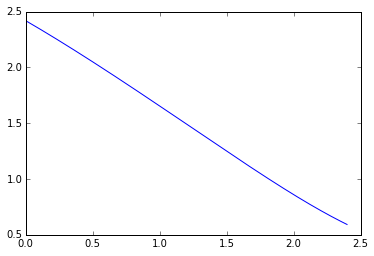

In [215]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.log(np.array([T/10.0+1.0 for T in range(2500)]))/np.log(10), np.log(np.array(S_test))/np.log(10))

### Calculate the energy lost by a charged particle with a given Z, mass, and K.E. through a given thickness of material (materials listed below) ###

Elements:
- Z = 1, 6, 7, 8, 11, 12, 13, 14, 18, 26, 29, 50, 74, 79, 82, 92

Composite Materials:
- water (liquid)
- concrete
- air
- adipose tissue

### Estimate the range of a charged particle through a given material by stepping through the material until the stopping power approaches zero (note, if you take the energy down to the lower limit of 2-3 MeV/nucleon, you can stop the calculation there--there isn't much range left after that energy) ###

First define the step size:

Thoughts:
- define with relationship to density? This would correct for state of matter
    - Could also use "S/rho" relationships from notes
    - maybe just use 1/rho in cm or something
- take a guess/iterate approach? as in, select an arbitrary thickness (1/2 of total or something), then try smaller and smaller fractions until the range converges?
    - Spawn multiple threads to speed up calculations? one per thickness?
        - How to even do this? would need to know E_n to calculate E_(n+1)

In [2]:
def transit(beam, target, thickness):
    """ Increments the energy of an incident particle (beam) after transiting through thickness of material target
        beam should be of type Beam
        target should be of type Material
        thickness is in cm
        
        thickness should be chose carefully
    """
    # First calculate specific mass stopping power
    
    # Then multiply specific mass stopping power by density of material
    
    # Then multiply by thickness
    
    # Subtract that result from the beam energy, beam.T

### Using geometric cross sections, estimate the fraction of the fluence undergoing a nuclear interaction as it goes through a given thickness of material ###

In [19]:
def geometric_cross_section(A1, A2):
    """ Gives the geometric cross section for the collision of two nuclei
        Inputs: A1, A2--mass number of nuclei
        Output: sigma--microscopic cross section (barns)
    """
    # First calculate "radius"
    def R(A):
        r_0 = 1.4 * 10 ** -13.0 # cm
        return r_0 * A ** (1.0 / 3.0)
    return math.pi * (R(A1) + R(A2)) ** 2

The fluence at distance $ x $ through a material is $$ \Phi = \Phi_0 e^{\Sigma x} = \Phi_0 e ^ {\sigma N x} $$